<a href="https://colab.research.google.com/github/bayuryunarko/ML-in-Financial-Analysis/blob/main/04MLFinancialAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating Stylized Facts of asset returns

In [ ]:
pip install yfinance

In [2]:
# import lib
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

In [4]:
# download data
df = yf.download('^GSPC', 
                       start= '1985-01-01',
                       end = '2018-12-31',
                       progress= False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-02,167.199997,167.199997,165.190002,165.369995,165.369995,67820000
1985-01-03,165.369995,166.110001,164.380005,164.570007,164.570007,88880000
1985-01-04,164.550003,164.550003,163.360001,163.679993,163.679993,77480000
1985-01-07,163.679993,164.710007,163.679993,164.240005,164.240005,86190000
1985-01-08,164.240005,164.589996,163.910004,163.990005,163.990005,92110000


In [5]:
df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how='any')
df.head()

,adj_close,log_rtn
Date,,
1985-01-03,164.570007,-0.004849
1985-01-04,163.679993,-0.005423
1985-01-07,164.240005,0.003416
1985-01-08,163.990005,-0.001523
1985-01-09,165.179993,0.007230


## Fact 1 - Non-Gaussian distribution of return

In [6]:
# calculate the normal PDF using the mean and standard deviation of the observed returns
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


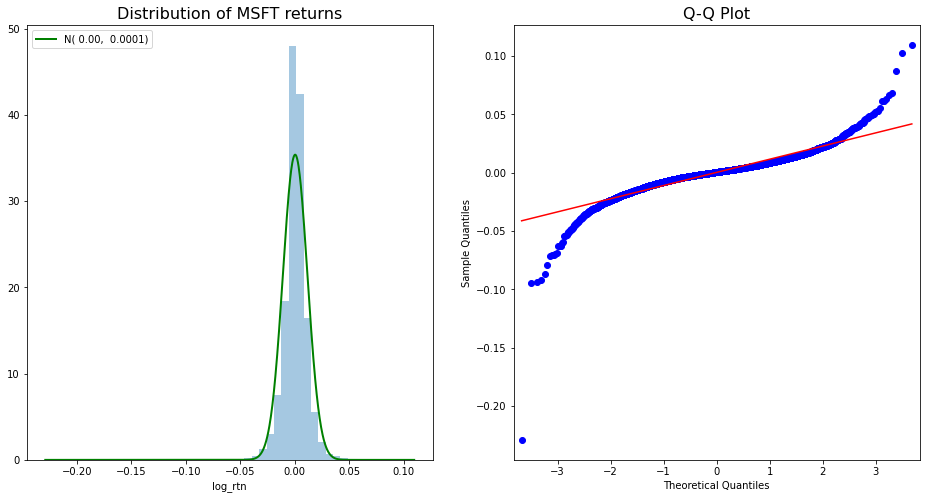

In [25]:
# plot the histogram and the Q-Q plot
fig, ax = plt.subplots(1,2, figsize=(16,8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of MSFT returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu: .2f}, {sigma**2: .4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot', fontsize=16)

plt.show()

In [23]:
jb_test = scs.jarque_bera(df.log_rtn.values)

# print the summary statistics of the log return
print('-------------------Descriptive Statistics--------------------')
print('Range of date : ', min(df.index.date), '-', max(df.index.date))
print('Number of observations :', df.shape[0])
print(f'Mean : {df.log_rtn.mean():.4f}')
print(f'Median : {df.log_rtn.median():.4f}')
print(f'Min : {df.log_rtn.min():.4f}')
print(f'Max : {df.log_rtn.max():.4f}')
print(f'Standard deviation : {df.log_rtn.std():.4f}')
print(f'Skewness : {df.log_rtn.skew():.4f}')
print(f'Kurtosis : {df.log_rtn.kurtosis():.4f}')
print(f'Jarque Bera Statistics : {jb_test[0]:.2f} with p-value {jb_test[1]:.2f}')

-------------------Descriptive Statistics--------------------
Range of date :  1985-01-03 - 2018-12-28
Number of observations : 8568
Mean : 0.0003
Median : 0.0006
Min : -0.2290
Max : 0.1096
Standard deviation : 0.0113
Skewness : -1.2628
Kurtosis : 28.0156
Jarque Bera Statistics : 282134.38 with p-value 0.00


## Fact 2 - Volatility Clustering

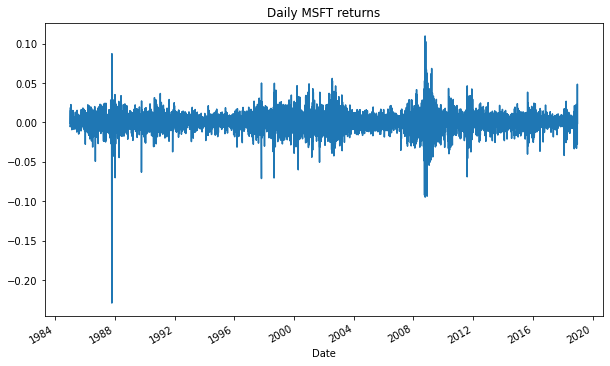

In [26]:
df.log_rtn.plot(title='Daily MSFT returns', figsize=(10,6))

plt.show()

## Fact 3 - Absence of Autocorrelation in return

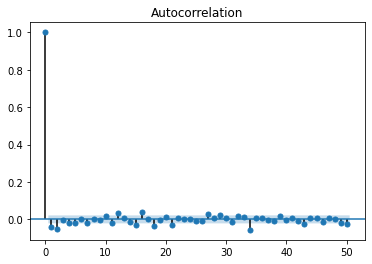

In [27]:
# define the paramaters for creating the Autocorrelation plots
N_LAGS = 50
Significance_level = 0.05

# run the following code to create ACF(Autocorrelation Function) plot of log return
acf = smt.graphics.plot_acf(df.log_rtn,
                            lags = N_LAGS,
                            alpha = Significance_level)

plt.show()

## Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

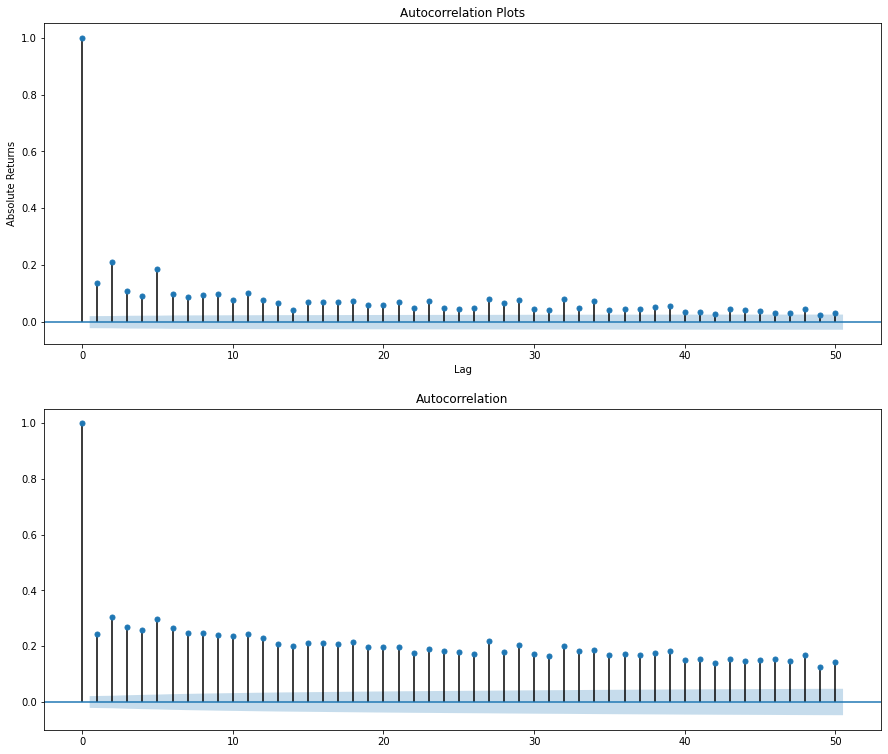

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(15,13))

smt.graphics.plot_acf(df.log_rtn**2, lags=N_LAGS, alpha=Significance_level, ax=ax[0])
ax[0].set(title='Autocorrelation Plots', ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, alpha=Significance_level, ax=ax[1])
ax[0].set(xlabel='Lag', ylabel='Absolute Returns')

plt.show()

## Fact 5 - Leverage effect

In [29]:
# calculate volatility measures as moving standard deviations
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

In [30]:
df.head()

,adj_close,log_rtn,moving_std_252,moving_std_21
Date,,,,
1985-01-03,164.570007,-0.004849,NaN,NaN
1985-01-04,163.679993,-0.005423,NaN,NaN
1985-01-07,164.240005,0.003416,NaN,NaN
1985-01-08,163.990005,-0.001523,NaN,NaN
1985-01-09,165.179993,0.007230,NaN,NaN


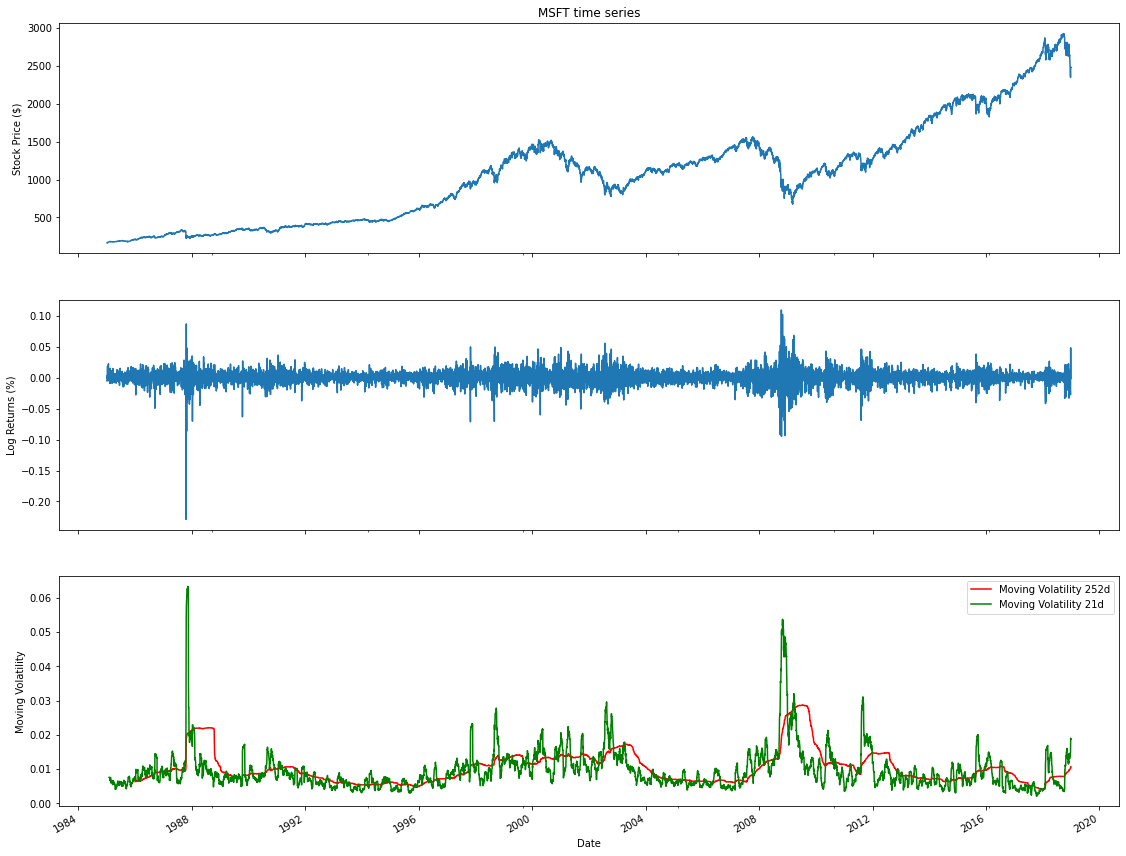

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(19, 16), sharex=True)

df.adj_close.plot(ax=ax[0])
ax[0].set(title='MSFT time series', ylabel='Stock Price ($)')

df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log Returns (%)')

df.moving_std_252.plot(ax=ax[2], color='r', label='Moving Volatility 252d')
df.moving_std_21.plot(ax=ax[2], color='g', label='Moving Volatility 21d')

ax[2].set(ylabel='Moving Volatility', xlabel='Date')
ax[2].legend()

plt.show()


## There's more

In [32]:
# download and preprocess the price of S&P 500 and VIX
df = yf.download(['^GSPC', '^VIX'],
                 start= '1985-01-01',
                 end= '2018-12-31',
                 progress= False)

df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'^GSPC':'sp500', '^VIX':'vix'})

In [33]:
# calculating log returns
df['log_rtn'] = np.log(df.sp500/df.sp500.shift(1))
df['vol_rtn'] = np.log(df.vix/df.vix.shift(1))
df.dropna(axis=0, how='any', inplace=True)

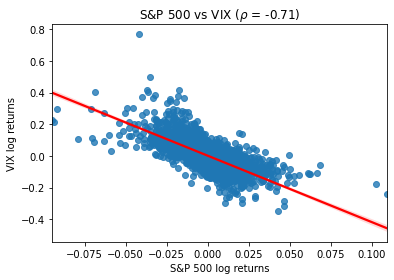

In [35]:
# Plot scatter plot with the returns on the axes and fit a regression line to identify trend
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df, line_kws={'color':'red'})
ax.set(title=f'S&P 500 vs VIX ($\\rho$ = {corr_coeff:.2f})',
       ylabel='VIX log returns',
       xlabel='S&P 500 log returns')

plt.show()
